In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

In [3]:
df = pd.read_json('/content/drive/MyDrive/ML_Data/term_labeled_texts_val.json')
df.head()

,tokenized_text,token_labels,new_terms
0,"[АНАЛИЗ, ЛЕКСИКО‐СЕМАНТИЧЕСКИХ, ОСОБЕННОСТЕЙ, ...","[O, B, E, B, E, O, O, O, O, O, O, O, O, O, O, ...","[ЛЕКСИКО‐СЕМАНТИЧЕСКИХ ОСОБЕННОСТЕЙ, РЕГИОНАЛЬ..."
1,"[ИСПОЛЬЗОВАНИЕ, МЕТОДА, УСЛОВНЫХ, СЛУЧАЙНЫХ, П...","[O, B, I, I, E, O, O, O, O, B, E, O, O, O, B, ...","[МЕТОДА УСЛОВНЫХ СЛУЧАЙНЫХ ПОЛЕЙ, РУССКОМ ЯЗЫК..."
2,"[МНОГОЗНАЧНОСТЬ, КАК, ПРИКЛАДНАЯ, ПРОБЛЕМА, :,...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...","[МНОГОЗНАЧНОСТЬ, ЛЕКСИКО-СЕМАНТИЧЕСКАЯ РАЗМЕТК..."
3,"[ОПИСАНИЕ, ФРАГМЕНТОВ, С, ПРЯМОЙ, РЕЧЬЮ, В, ПО...","[O, O, O, B, E, O, B, E, B, E, O, O, O, O, O, ...","[ПРЯМОЙ РЕЧЬЮ, ПОВЕСТВОВАТЕЛЬНЫХ КНИГАХ, ЕВРЕЙ..."
4,"[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ, ВЫРАЖЕНИЙ, НА...","[S, S, B, E, O, O, B, E, O, O, O, O, O, B, E, ...","[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ ВЫРАЖЕНИЙ, НЕР..."


In [4]:
from transformers import TokenClassificationPipeline, AutoTokenizer, AutoModelForTokenClassification

In [5]:
tokenizer_term = AutoTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [6]:
def postprocess_output(output):

  id2tag = {0: 'O', 1: 'S', 2: 'B', 3: 'I', 4: 'E'}

  string = ''
  tags = []
  last_token_end = 0

  for token in output:
    # сначала обработаем тег
    if '_' in token['entity']:
      tag = id2tag[int(token['entity'].split('_')[1])]
    else:
      tag = token['entity']

    if token['word'][0] == '▁':
      # если токен - или начало слова, или полное слово
      if last_token_end != token['start']:
        string += ' '

      string += token['word']
      tags.append(tag)

    else:
      # если токен - середина слова или конец
      string += token['word'].replace('#', '')

    last_token_end = token['end']

  return list(zip(string.split(), tags))

In [7]:
checkpoint = '/content/drive/MyDrive/ML/Project_Terminology_2/Model_Term_XLMR' # модель училась 10 эпох

In [8]:
model_term = AutoModelForTokenClassification.from_pretrained(checkpoint)

In [9]:
termbert = TokenClassificationPipeline(model=model_term, tokenizer=tokenizer_term, task="term")

In [10]:
postprocess_output(termbert('В данной статье описываются основные принципы работы синтаксического парсера русского языка LPaRus , разработанного на основе лингвистических технологий компании Megaputer Intelligence .'))

[('▁В', 'O'),
 ('▁данной', 'O'),
 ('▁статье', 'O'),
 ('▁описываются', 'O'),
 ('▁основные', 'O'),
 ('▁принципы', 'O'),
 ('▁работы', 'O'),
 ('▁синтаксического', 'B'),
 ('▁парсера', 'E'),
 ('▁русского', 'B'),
 ('▁языка', 'E'),
 ('▁LPaRus', 'O'),
 ('▁,', 'O'),
 ('▁разработанного', 'O'),
 ('▁на', 'O'),
 ('▁основе', 'O'),
 ('▁лингвистических', 'B'),
 ('▁технологий', 'E'),
 ('▁компании', 'O'),
 ('▁Megaputer', 'O'),
 ('▁Intelligence', 'O'),
 ('▁.', 'O')]

In [11]:
def get_predicted_labels(x):

  labels_pred = []

  text = ' '.join(x['tokenized_text'])
  output = postprocess_output(termbert(text))
  tokens = [i[1] for i in output]
  for i in tokens:
    labels_pred.append(i)

  return labels_pred


In [12]:
df['pred_labels'] = df.apply(get_predicted_labels, axis=1)

In [32]:
df = df[['tokenized_text', 'token_labels', 'pred_labels']]
df.head(15)

,tokenized_text,token_labels,pred_labels
0,"[ИСПОЛЬЗОВАНИЕ, МЕТОДА, УСЛОВНЫХ, СЛУЧАЙНЫХ, П...","[O, B, I, I, E, O, O, O, O, B, E, O, O, O, B, ...","[O, O, B, I, E, O, B, E, O, B, E, O, O, O, O, ..."
1,"[МНОГОЗНАЧНОСТЬ, КАК, ПРИКЛАДНАЯ, ПРОБЛЕМА, :,...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ..."
2,"[ОПИСАНИЕ, ФРАГМЕНТОВ, С, ПРЯМОЙ, РЕЧЬЮ, В, ПО...","[O, O, O, B, E, O, B, E, B, E, O, O, O, O, O, ...","[O, S, O, B, E, O, B, E, B, E, O, O, O, O, S, ..."
3,"[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ, ВЫРАЖЕНИЙ, НА...","[S, S, B, E, O, O, B, E, O, O, O, O, O, B, E, ...","[O, I, I, E, O, O, B, E, O, O, O, O, O, B, E, ..."
4,"[ФРАЗОВАЯ, АКЦЕНТУАЦИЯ, В, СЛОЖНЫХ, ПРЕДЛОЖЕНИ...","[B, E, O, B, E, O, B, E, O, B, E, O, O, O, B, ...","[B, E, O, B, E, O, B, E, O, B, E, O, O, O, B, ..."
5,"[Лексико, -, грамматические, базы, данных, и, ...","[B, I, I, I, E, O, O, O, O, B, I, E, O, O, S, ...","[B, I, I, I, E, O, O, O, O, B, I, E, O, O, B, ..."
6,"[ЛЕКСИКАЛИЗОВАННАЯ, ПРОСОДИЯ, И, ПОЛИСЕМИЯ, ДИ...","[B, E, O, S, B, E, O, O, O, B, I, E, O, O, B, ...","[B, E, O, S, B, E, O, O, O, O, O, E, O, O, B, ..."
7,"[ИНТОНАЦИЯ, РЕЧЕВЫХ, ДЕЙСТВИЙ, ., МНОГОЗНАЧНОС...","[S, B, E, O, S, O, B, E, O, O, O, B, I, I, I, ...","[S, B, E, O, S, O, O, S, O, O, O, O, I, O, I, ..."
8,"[Особенности, подготовки, терминов, для, русск...","[O, O, S, O, O, O, O, S, O, B, E, O, O, O, O, ...","[O, O, S, O, O, O, O, S, O, B, E, O, O, O, O, ..."
9,"[МЕСТО, МЕЖЪЯЗЫКОВОЙ, ДЕВИАТОЛОГИИ, В, ОБЩЕЙ, ...","[O, B, E, O, B, I, E, O, S, O, O, O, S, O, O, ...","[O, B, E, O, B, E, O, O, S, O, O, O, S, O, O, ..."


In [34]:
num = 24
for i in range(len(df['tokenized_text'][num])):
  print(df['tokenized_text'][num][i], df['token_labels'][num][i], df['pred_labels'][num][i])

Cемантические B B
источники E E
уступительности O S
Уступительность O S
— O O
сложный B O
смысл E O
, O O
и O O
обычно O O
слова S S
с O O
уступительным B B
значением E E
развиваются O O
из O O
слов S S
с O O
более O O
простыми O O
, O O
первичными B O
смыслами E E
— O O
например O O
, O O
условия O O
( O O
если O O
и O O
, O O
даже O O
если O O
) O O
, O O
желания O O
( O O
хотя O O
, O O
хоть O O
) O O
, O O
одновременности O O
( O O
в O O
то O O
время O O
как O O
, O O
тогда O O
как O O
) O O
, O O
степени O O
( O O
тем O O
не O O
менее O O
, O O
по O O
крайней O O
мере O O
) O O
, O O
соответствия O O
действительности O O
( O O
правда O O
) O O
, O O
вероятности O S
( O O
конечно O O
) O O
и O O
другими O O
. O O


In [14]:
def len_check(x):

  return len(x['token_labels']) == len(x['pred_labels'])

In [15]:
df['len_check'] = df.apply(len_check, axis=1)

In [16]:
df['len_check'].value_counts()

len_check
True     48
False     2
Name: count, dtype: int64

In [17]:
df = df[df['len_check'] == True].reset_index(drop=True)

In [18]:
df

,tokenized_text,token_labels,new_terms,pred_labels,len_check
0,"[ИСПОЛЬЗОВАНИЕ, МЕТОДА, УСЛОВНЫХ, СЛУЧАЙНЫХ, П...","[O, B, I, I, E, O, O, O, O, B, E, O, O, O, B, ...","[МЕТОДА УСЛОВНЫХ СЛУЧАЙНЫХ ПОЛЕЙ, РУССКОМ ЯЗЫК...","[O, O, B, I, E, O, B, E, O, B, E, O, O, O, O, ...",True
1,"[МНОГОЗНАЧНОСТЬ, КАК, ПРИКЛАДНАЯ, ПРОБЛЕМА, :,...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...","[МНОГОЗНАЧНОСТЬ, ЛЕКСИКО-СЕМАНТИЧЕСКАЯ РАЗМЕТК...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...",True
2,"[ОПИСАНИЕ, ФРАГМЕНТОВ, С, ПРЯМОЙ, РЕЧЬЮ, В, ПО...","[O, O, O, B, E, O, B, E, B, E, O, O, O, O, O, ...","[ПРЯМОЙ РЕЧЬЮ, ПОВЕСТВОВАТЕЛЬНЫХ КНИГАХ, ЕВРЕЙ...","[O, S, O, B, E, O, B, E, B, E, O, O, O, O, S, ...",True
3,"[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ, ВЫРАЖЕНИЙ, НА...","[S, S, B, E, O, O, B, E, O, O, O, O, O, B, E, ...","[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ ВЫРАЖЕНИЙ, НЕР...","[O, I, I, E, O, O, B, E, O, O, O, O, O, B, E, ...",True
4,"[ФРАЗОВАЯ, АКЦЕНТУАЦИЯ, В, СЛОЖНЫХ, ПРЕДЛОЖЕНИ...","[B, E, O, B, E, O, B, E, O, B, E, O, O, O, B, ...","[ФРАЗОВАЯ АКЦЕНТУАЦИЯ, СЛОЖНЫХ ПРЕДЛОЖЕНИЯХ, П...","[B, E, O, B, E, O, B, E, O, B, E, O, O, O, B, ...",True
5,"[Лексико, -, грамматические, базы, данных, и, ...","[B, I, I, I, E, O, O, O, O, B, I, E, O, O, S, ...","[Лексико-грамматические базы данных, диалектны...","[B, I, I, I, E, O, O, O, O, B, I, E, O, O, B, ...",True
6,"[ЛЕКСИКАЛИЗОВАННАЯ, ПРОСОДИЯ, И, ПОЛИСЕМИЯ, ДИ...","[B, E, O, S, B, E, O, O, O, B, I, E, O, O, B, ...","[ЛЕКСИКАЛИЗОВАННАЯ ПРОСОДИЯ, ПОЛИСЕМИЯ, ДИСКУР...","[B, E, O, S, B, E, O, O, O, O, O, E, O, O, B, ...",True
7,"[ИНТОНАЦИЯ, РЕЧЕВЫХ, ДЕЙСТВИЙ, ., МНОГОЗНАЧНОС...","[S, B, E, O, S, O, B, E, O, O, O, B, I, I, I, ...","[ИНТОНАЦИЯ, РЕЧЕВЫХ ДЕЙСТВИЙ, МНОГОЗНАЧНОСТЬ, ...","[S, B, E, O, S, O, O, S, O, O, O, O, I, O, I, ...",True
8,"[Особенности, подготовки, терминов, для, русск...","[O, O, S, O, O, O, O, S, O, B, E, O, O, O, O, ...","[терминов, тезауруса, компьютерной лингвистике...","[O, O, S, O, O, O, O, S, O, B, E, O, O, O, O, ...",True
9,"[МЕСТО, МЕЖЪЯЗЫКОВОЙ, ДЕВИАТОЛОГИИ, В, ОБЩЕЙ, ...","[O, B, E, O, B, I, E, O, S, O, O, O, S, O, O, ...","[МЕЖЪЯЗЫКОВОЙ ДЕВИАТОЛОГИИ, ОБЩЕЙ ТЕОРИИ ОШИБО...","[O, B, E, O, B, E, O, O, S, O, O, O, S, O, O, ...",True


In [19]:
labels_pred = []

for i in range(48):
  for n in df['pred_labels'][i]:
    labels_pred.append(n)

In [20]:
len(labels_pred)

4273

In [21]:
labels_true = []

for i in range(48):
  for i in df['token_labels'][i]:
    labels_true.append(i)

In [22]:
len(labels_true)

4273

In [23]:
import numpy

In [24]:
import matplotlib.pyplot as plt

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_true = numpy.array(labels_true)
y_pred = numpy.array(labels_pred)

In [26]:
y_true.shape

(4273,)

In [27]:
y_pred.shape

(4273,)

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           B       0.80      0.80      0.80       409
           E       0.87      0.86      0.86       409
           I       0.69      0.72      0.70       156
           O       0.95      0.96      0.95      2979
           S       0.80      0.75      0.77       320

    accuracy                           0.91      4273
   macro avg       0.82      0.82      0.82      4273
weighted avg       0.91      0.91      0.91      4273



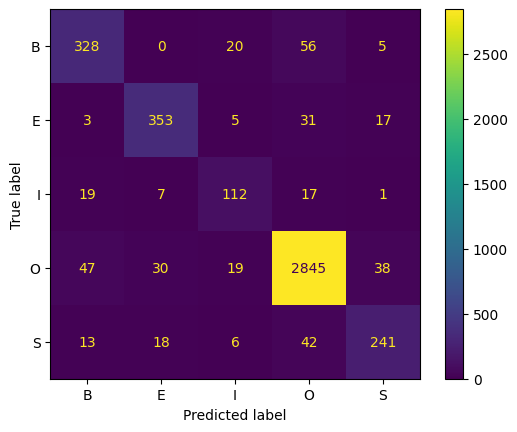

In [29]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()